In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zeeshier/student-admission-records")

print("Path to dataset files:", path)

100%|██████████| 2.06k/2.06k [00:00<00:00, 3.53MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zeeshier/student-admission-records/versions/1


In [ ]:
import os
import pandas as pd
# Define the file path
file_path = os.path.join("/root/.cache/kagglehub/datasets/zeeshier/student-admission-records/versions/1",
                         "student_admission_record_dirty.csv")

df = pd.read_csv(file_path)

# Identify missing values
missing_summary = df.isnull().sum()

# Print the missing values summary
print(missing_summary)


Name                      10
Age                       10
Gender                    10
Admission Test Score      11
High School Percentage    11
City                      10
Admission Status          10
dtype: int64


In [ ]:
from sklearn.impute import KNNImputer
numerical_cols = df.select_dtypes(include=["number"]).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns
mean_values = {col: df[col].mean() for col in numerical_cols if df[col].isnull().sum() > 0}
df.fillna(mean_values, inplace=True)
mode_values = {col: df[col].mode()[0] for col in categorical_cols if df[col].isnull().sum() > 0}
df.fillna(mode_values, inplace=True)
imputer = KNNImputer(n_neighbors=5)
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
missing_summary_after = df.isnull().sum()
print("Missing Values After Imputation:\n", missing_summary_after)

Missing Values After Imputation:
 Name                      0
Age                       0
Gender                    0
Admission Test Score      0
High School Percentage    0
City                      0
Admission Status          0
dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# Standardization (Z-score scaling)
df_standardized = df.copy()
df_standardized[numerical_cols] = standard_scaler.fit_transform(df[numerical_cols])

# Normalization (Min-Max scaling)
df_normalized = df.copy()
df_normalized[numerical_cols] = min_max_scaler.fit_transform(df[numerical_cols])


print("Standardized Numerical Features:\n", df_standardized[numerical_cols].head())
print("Normalized Numerical Features:\n", df_normalized[numerical_cols].head())

Standardized Numerical Features:
         Age  Admission Test Score  High School Percentage
0  0.986563             -1.707425               -0.406488
1  0.301407              1.317567               -0.895971
2 -0.612135              0.700222                0.000000
3 -0.612135             -1.398752                0.575474
4  0.073021             -0.781407               -0.872006
Normalized Numerical Features:
     Age  Admission Test Score  High School Percentage
0  1.00              0.354839                0.654772
1  0.88              0.670968                0.586971
2  0.72              0.606452                0.711077
3  0.72              0.387097                0.790788
4  0.84              0.451613                0.590290


In [ ]:
import numpy as np

from scipy.signal import savgol_filter
noisy_column = numerical_cols[0]
df['noisy_' + noisy_column] = df[noisy_column] + np.random.normal(loc=0, scale=5, size=df.shape[0])

# Moving Average
df['smoothed_moving_avg'] = df['noisy_' + noisy_column].rolling(window=5).mean()

# Savitzky-Golay Filter
df['smoothed_savgol'] = savgol_filter(df['noisy_' + noisy_column], window_length=5, polyorder=2)


In [ ]:
noisy_column_name = 'noisy_' + noisy_column
z_scores = (df[noisy_column_name] - df[noisy_column_name].mean()) / df[noisy_column_name].std()
threshold = 3
outliers = df[(z_scores > threshold) | (z_scores < -threshold)]

# Step 6: Display Outliers
print("Detected Outliers:\n", outliers)

Detected Outliers:
         Name  Age  Gender  Admission Test Score  High School Percentage  \
23     Aliya -1.0    Male                 101.0                   54.59   
113  Zunaira -1.0  Female                  84.0                   58.77   

       City Admission Status  noisy_Age  smoothed_moving_avg  smoothed_savgol  
23   Quetta         Rejected  -5.475602            16.687795         6.151394  
113  Quetta         Rejected  -1.166695            16.487053         7.784059  


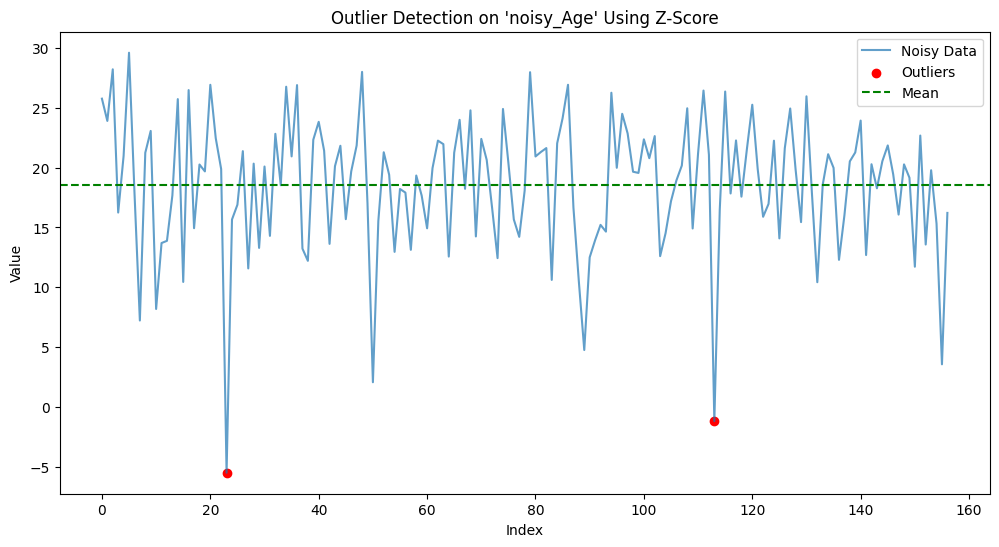

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[noisy_column_name], label="Noisy Data", alpha=0.7)
plt.scatter(outliers.index, outliers[noisy_column_name], color="red", label="Outliers")
plt.axhline(df[noisy_column_name].mean(), color="green", linestyle="--", label="Mean")
plt.title(f"Outlier Detection on '{noisy_column_name}' Using Z-Score")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

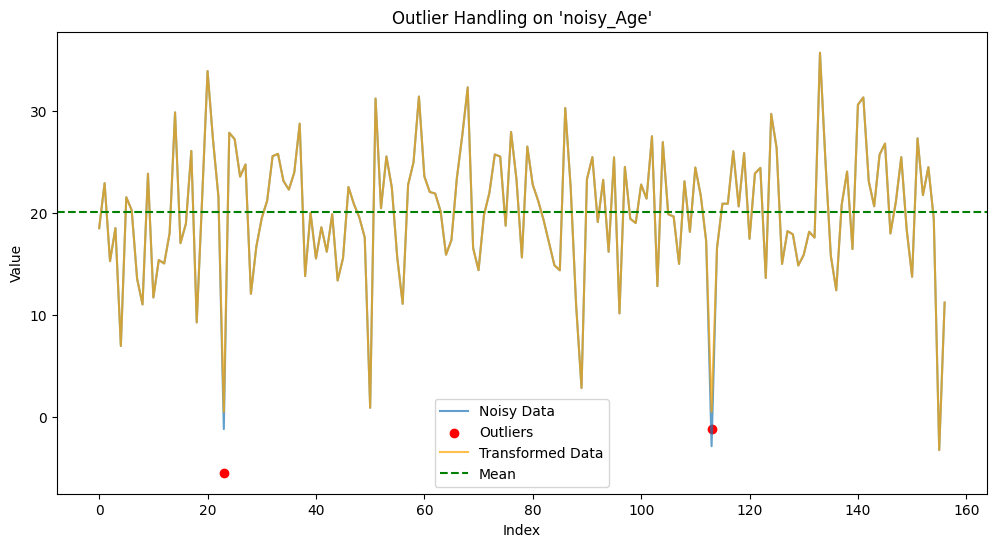

In [ ]:
df_removed_outliers = df[(z_scores <= threshold) & (z_scores >= -threshold)]

df['transformed_' + noisy_column_name] = np.where(
    z_scores > threshold, df[noisy_column_name].mean() + threshold * df[noisy_column_name].std(),
    np.where(z_scores < -threshold, df[noisy_column_name].mean() - threshold * df[noisy_column_name].std(),
             df[noisy_column_name])
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[noisy_column_name], label="Noisy Data", alpha=0.7)
plt.scatter(outliers.index, outliers[noisy_column_name], color="red", label="Outliers")
plt.plot(df.index, df['transformed_' + noisy_column_name], label="Transformed Data", alpha=0.7, color="orange")
plt.axhline(df[noisy_column_name].mean(), color="green", linestyle="--", label="Mean")
plt.title(f"Outlier Handling on '{noisy_column_name}'")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [23]:
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 5: Mutual Information (Filter Method)
mutual_info_scores = mutual_info_classif(X_train, y_train)
mutual_info_features = pd.Series(mutual_info_scores, index=X.columns).nlargest(5)
print("\nTop 5 Features (Mutual Information):\n", mutual_info_features)

# Step 6: Recursive Feature Elimination (Wrapper Method)
logistic_model = LogisticRegression(max_iter=500, random_state=42)
rfe = RFE(estimator=logistic_model, n_features_to_select=5)
rfe.fit(X_train, y_train)
rfe_features = pd.Series(rfe.support_, index=X.columns).where(lambda x: x == True).dropna().index
print("\nTop 5 Features (RFE):\n", list(rfe_features))

# Step 7: Lasso Regression (Embedded Method)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)
lasso_features = lasso_coefficients.nlargest(5).index
print("\nTop 5 Features (Lasso Regression):\n", list(lasso_features))

# Step 8: Compare Results
comparison_df = pd.DataFrame({
    "Mutual Information": mutual_info_features.index,
    "RFE": list(rfe_features),
    "Lasso": list(lasso_features),
})
print("\nFeature Selection Comparison:\n")
print(comparison_df)


Top 5 Features (Mutual Information):
 Age                       0.042952
Admission Test Score      0.012415
High School Percentage    0.000000
dtype: float64

Top 5 Features (RFE):
 ['Age', 'Admission Test Score', 'High School Percentage']


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=5 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(



Top 5 Features (Lasso Regression):
 ['Age', 'Admission Test Score', 'High School Percentage']

Feature Selection Comparison:

       Mutual Information                     RFE                   Lasso
0                     Age                     Age                     Age
1    Admission Test Score    Admission Test Score    Admission Test Score
2  High School Percentage  High School Percentage  High School Percentage


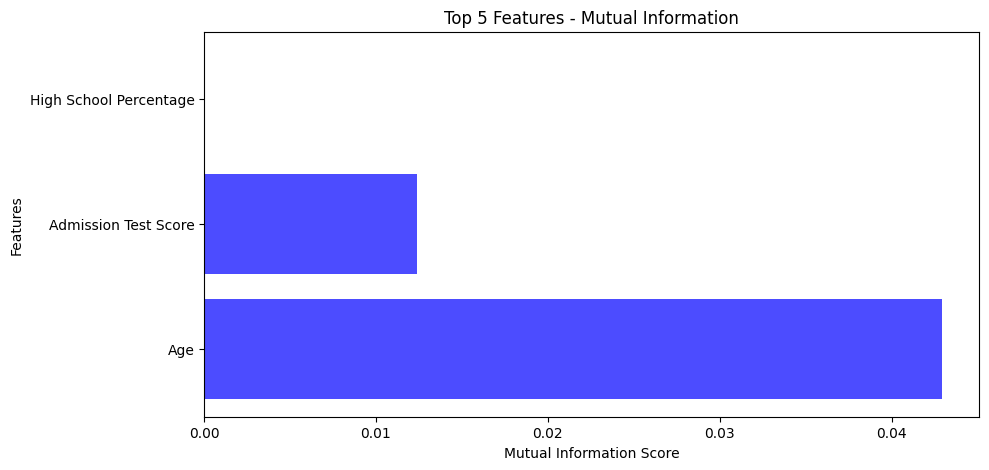

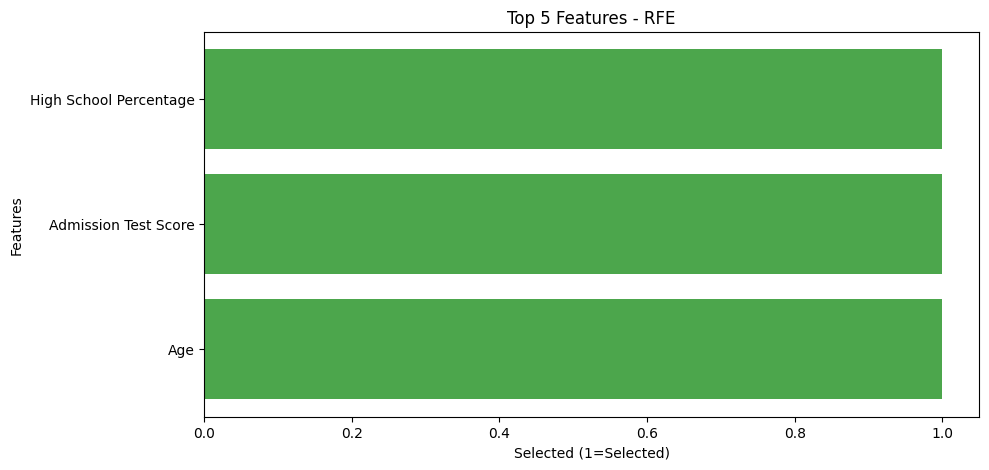

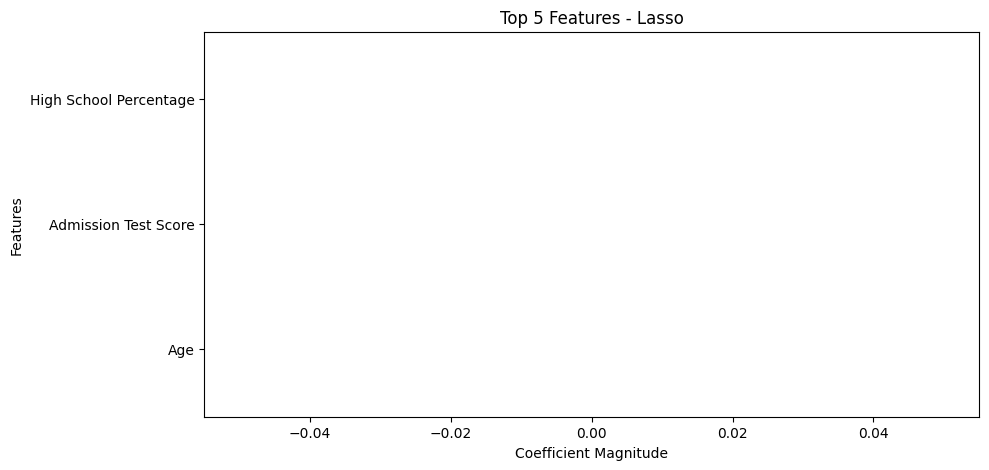

In [24]:
import matplotlib.pyplot as plt

# Prepare data for plotting
methods = ["Mutual Information", "RFE", "Lasso"]
features = [mutual_info_features, rfe_features, lasso_features]

# Plot feature importance for each method
for method, feature_set in zip(methods, features):
    plt.figure(figsize=(10, 5))
    if method == "Mutual Information":
        plt.barh(feature_set.index, feature_set.values, alpha=0.7, color='blue')
        plt.title(f"Top 5 Features - {method}")
        plt.xlabel("Mutual Information Score")
        plt.ylabel("Features")
    elif method == "RFE":
        plt.barh(feature_set, [1] * len(feature_set), alpha=0.7, color='green')  # RFE ranks features; binary for top features
        plt.title(f"Top 5 Features - {method}")
        plt.xlabel("Selected (1=Selected)")
        plt.ylabel("Features")
    elif method == "Lasso":
        plt.barh(feature_set, lasso_coefficients[feature_set], alpha=0.7, color='orange')
        plt.title(f"Top 5 Features - {method}")
        plt.xlabel("Coefficient Magnitude")
        plt.ylabel("Features")

    plt.show()
